# Predicting Work Placement Status using Academic Percentages
DSCI 100 Project Report

**Group 005-32**: Imanjosh Chahal, Kahsennaró-roks Deom, Romina Mahinpei

## I. Introduction
For students, getting a work placement is of great concern. Many students work on obtaining high academic averages so that they can be recognized by employers and ultimately secure a work placement. Further research also suggests that employers value high academic percentages when hiring. According to a recent study, the GPAs of graduate students is often regarded as a strong determinant of how well a student will perform at their prospective job (Mehmetaj et al., 2021). Another study also noted how observed graduates with better GPAs attained higher starting salaries, with every point increase in GPA roughly contributing to a 10% increase in starting salary (Sandvig, 2005).

After reading about the value given to high GPAs by employers, we decided to investigate the following research question: **can we predict whether an employer will hire students based on their secondary school, high school, and undergrad degree acedemic percentages?** We aim to answer this question using a classifier trained by the K-nearest neighbours (KNN) algorithm with the dataset described below.

Our chosen dataset is collected by Jain University and published on Kaggle (Roshan, 2020). The dataset contains 215 observations and 15 variables. This project only uses 6 out of the 15 variables and does not use the 9 remaining categorical variables. Our target variable is status of placement (referred to as status in the dataset and throughout the rest of this report), indicating whether a student received a work placement position or not. Our potential predictors include secondary school, high school, undergrad degree, MBA degree, and employability test percentages (referred to as ssc_p, hsc_p, degree_p, mba_p, etest_p respectively in the dataset and throughout the rest of this report). However, after eliminating potential irrelevant predictors as later described, our final predictors include secondary school, high school, and undergrad degree percentages.

## II. Preliminary Exploration
We begin by loading packages and reading the dataset, as highlighted in **Table 1**.

In [1]:
# install packages, load libraries, and set seed
set.seed(1000)
library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)
library(cowplot)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# read data from the web
data_url <- "https://raw.githubusercontent.com/DG1606/CMS-R-2020/7f00d6b5e20d99a933c582d8b544fc4d04528462/Placement_Data_Full_Class.csv"
data_original <- read_csv(data_url)

head(data_original)

Parsed with column specification:
cols(
  sl_no = col_double(),
  gender = col_character(),
  ssc_p = col_double(),
  ssc_b = col_character(),
  hsc_p = col_double(),
  hsc_b = col_character(),
  hsc_s = col_character(),
  degree_p = col_double(),
  degree_t = col_character(),
  workex = col_character(),
  etest_p = col_double(),
  specialisation = col_character(),
  mba_p = col_double(),
  status = col_character(),
  salary = col_double()
)



sl_no,gender,ssc_p,ssc_b,hsc_p,hsc_b,hsc_s,degree_p,degree_t,workex,etest_p,specialisation,mba_p,status,salary
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
1,M,67.00,Others,91.00,Others,Commerce,58.00,Sci&Tech,No,55.0,Mkt&HR,58.80,Placed,270000
2,M,79.33,Central,78.33,Others,Science,77.48,Sci&Tech,Yes,86.5,Mkt&Fin,66.28,Placed,200000
3,M,65.00,Central,68.00,Central,Arts,64.00,Comm&Mgmt,No,75.0,Mkt&Fin,57.80,Placed,250000
4,M,56.00,Central,52.00,Central,Science,52.00,Sci&Tech,No,66.0,Mkt&HR,59.43,Not Placed,NA
5,M,85.80,Central,73.60,Central,Commerce,73.30,Comm&Mgmt,No,96.8,Mkt&Fin,55.50,Placed,425000
6,M,55.00,Others,49.80,Others,Science,67.25,Sci&Tech,Yes,55.0,Mkt&Fin,51.58,Not Placed,NA


<body><center> <b>Table 1</b>: Variables and observations from the original dataset by B. Roshan.</center><body>

We then split 75% of the data into training data and treat the remaining 25% as testing data. We specifically take a higher percentage of our data as training data since the training data is what gets used to train the model. This suggests that having more training data will increase the chances of training a more accurate model, thus leading to our decision. 

In [3]:
# treat status as a factor
data_original <- mutate(data_original, status = as_factor(status))

# split data into testing set (75% of original data) and training set (25% of original data)
data_split <- initial_split(data_original, prop = 0.75, strata = status)
data_train <- training(data_split)
data_test <- testing(data_split)

We then select the potential predictors and summarize the training data to obtain the means of each predictor in **Table 2**.

In [4]:
# summarize training data
summary_table <- data_train %>%
    select(status, ssc_p, hsc_p, degree_p, mba_p, etest_p) %>%
    group_by(status) %>%
    summarize(count = n(), 
              mean_ssc_p = mean(ssc_p), 
              mean_hsc_p = mean(hsc_p), 
              mean_degree_p = mean(degree_p), 
              mean_mba_p = mean(mba_p), 
              mean_etest_p = mean(etest_p))
summary_table

`summarise()` ungrouping output (override with `.groups` argument)



status,count,mean_ssc_p,mean_hsc_p,mean_degree_p,mean_mba_p,mean_etest_p
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Placed,111,72.49216,70.08414,69.14054,63.00216,73.37874
Not Placed,51,58.34275,58.46745,61.40373,62.01373,68.38902


<body><center> <b>Table 2</b>: Mean academic percentages for "Placed" and "Not Placed" students.</center><body>

**Table 2** shows that Placed students appear to have higher average academic percentages than Not Placed students. We also display the distributions of all potential predictors in **Figure 1** and again observe that Placed students appear to have higher percentages than Not Placed students. These observations both suggest that students can be classified into two binary groups (Placed vs. Not Placed), thus verifying that this scenario is an ideal candidate for classification.

<b>Note:</b> *We acknowledge that our data does not have an equal proportion of both labels and contains more Placed than Not Placed labels. After a lot of consideration and consultations with TAs and professors, we decided to not oversample the data because we then wouldn't be able to use the built-in cross-validation functions and would have to perform cross-validation manually. Furthermore, seeing how our classes weren't extremely unbalanced, we did not think that it would be worth to perform cross-validation manually, which is much more error-prone and also significantly decreases code readability.*

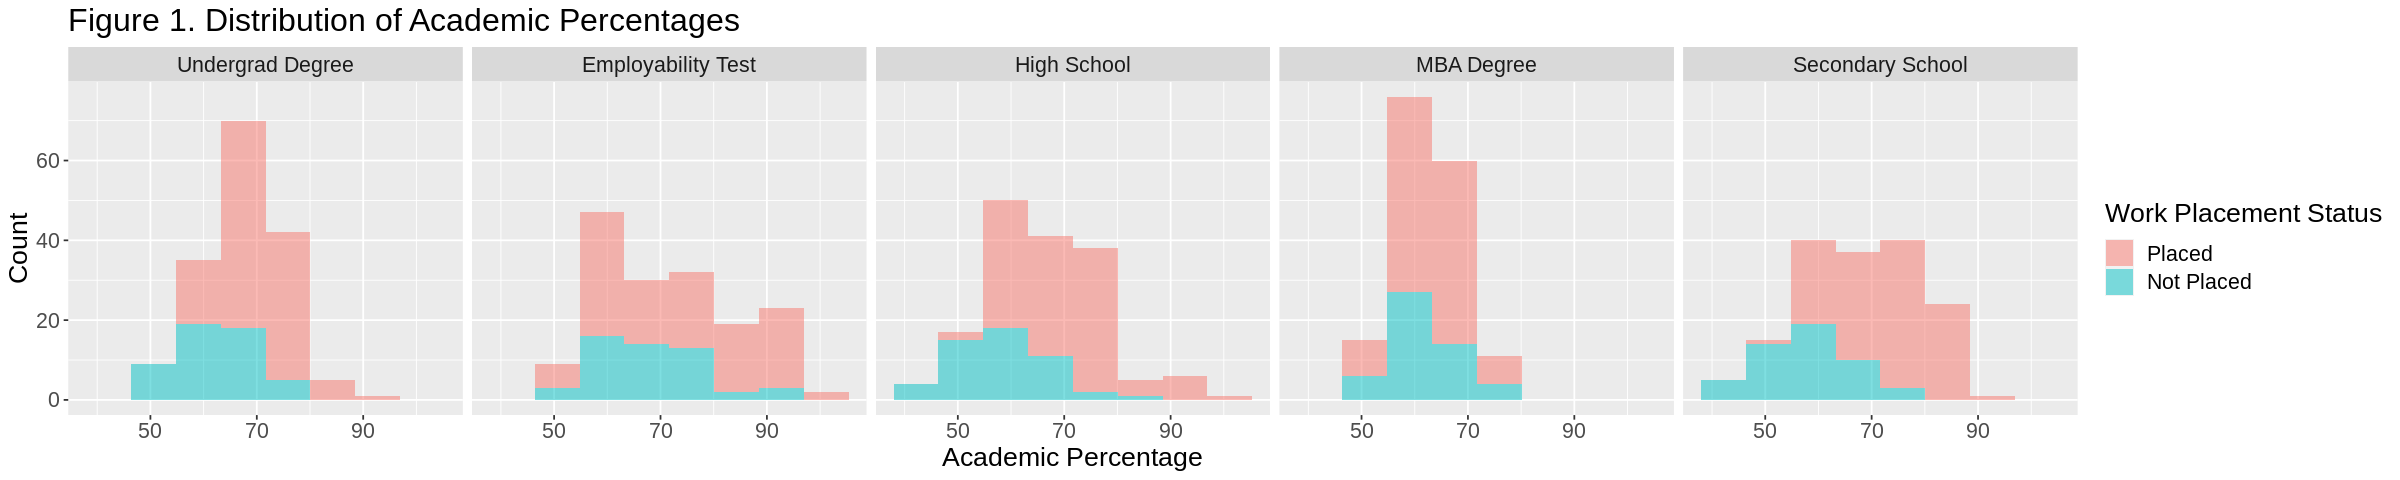

In [5]:
options(repr.plot.width = 20, repr.plot.height = 4)

# adjust data format so that facet_grid can be applied
data_plot <- data_train %>%
    select(status, ssc_p, hsc_p, degree_p, mba_p, etest_p) %>%
    pivot_longer(cols = ssc_p:etest_p,
                 names_to = "degree_type",
                 values_to = "gpa_p")

gpa_labels <- c(ssc_p = "Secondary School", 
                hsc_p = "High School", 
                degree_p = "Undergrad Degree",
                mba_p = "MBA Degree", 
                etest_p = "Employability Test")

# create histograms to show distributions of predictors
distribution_predictors <- ggplot(data_plot, aes(x = gpa_p, fill = status)) +
    geom_histogram(bins = 8, alpha = 0.5) + 
    labs(x = "Academic Percentage", y = "Count", fill = "Work Placement Status") +
    facet_grid(. ~ degree_type, labeller = labeller(degree_type = gpa_labels)) + 
    ggtitle("Figure 1. Distribution of Academic Percentages") +
    theme(text = element_text(size = 16))
distribution_predictors

## III. Methods
### *Selecting Relevant Predictors*
We start by finding the relevant predictors from the following list of pontential predictors: secondary school, high school, undergrad degree, MBA degree, and employability test percentages. For an initial check of relevancy, we create scatterplots for all possible pairs of our potential predictors and display the results in **Figure 2**.

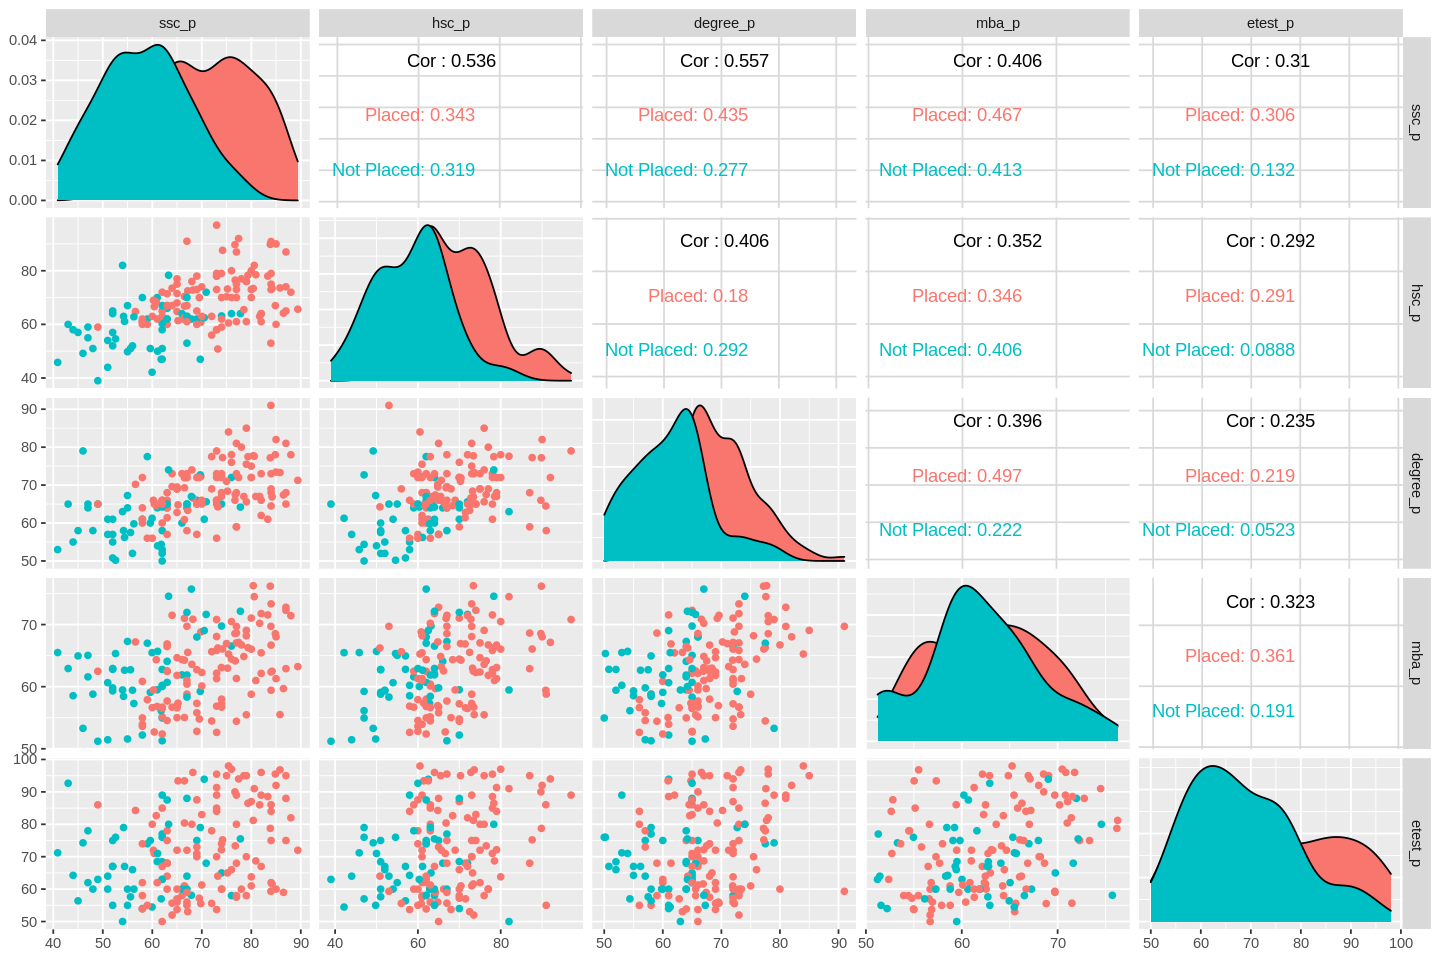

In [6]:
options(repr.plot.width = 12, repr.plot.height = 8)

# create a ggpairs plot
ggpairs <- data_train %>% 
    select(status, ssc_p, hsc_p, degree_p, mba_p, etest_p) %>% 
    ggpairs(col = 2:6, aes(color = status))

ggpairs

<body><center> <b>Figure 2</b>: Scatterplots of all possible pairings of potential predictors in our dataset. The red color depicts the "Placed" students and the blue color depicts the "Not Placed" students.</center><body>

From **Figure 2**, we observe that MBA percentages (mba_p) and employability test percentages (etest_p) are rather scattered when paired with other predictors and do not form very distinct groups relative to the status label. This suggests that they may not be good predictors to use for classification. On the other hand, we observe that the other predictors form fairly distinct groups relative to the status label when paired with each other, thus suggesting that they may be ideal predictors to use in our model.

To get a numerical confirmation of what predictors may be relevant in addition to the visual confirmation from **Figure 2**, we use the Forward Selection algorithm provided in the DSCI 100 textbook.

In [7]:
# determine relevant predictors for analysis using the forward selection algorithm
placement_subset <- data_train %>% 
  select(status, 
         ssc_p, 
         hsc_p, 
         degree_p, 
         mba_p, 
         etest_p)

names <- colnames(placement_subset %>% select(-status))

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) %>%
     set_engine("kknn") %>%
     set_mode("classification")

# create a 5-fold cross-validation object
placement_vfold <- vfold_cv(placement_subset, v = 5, strata = status)

# store the total number of predictors
n_total <- length(names)

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("status", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        placement_recipe <- recipe(as.formula(model_string), 
                                data = placement_subset) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(placement_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = placement_vfold, grid = 10) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,status ~ ssc_p,0.8080882
2,status ~ ssc_p+hsc_p,0.8514706
3,status ~ ssc_p+hsc_p+mba_p,0.8334559
4,status ~ ssc_p+hsc_p+mba_p+degree_p,0.8459559
5,status ~ ssc_p+hsc_p+mba_p+degree_p+etest_p,0.8213235


<body><center> <b>Table 3</b>: Accuracy results of the Forward Selection algorithm.</center><body>

Starting with secondary school percentage as our only predictor and an initial accuracy of 80.8%, **Table 3** shows that adding high school percentage and undergrad degree percentage increased the model accuracy while adding MBA percentage and employability test percentage decreased the model accuracy. Using these numerical results along with the visual confirmation from our scatterplots, we choose to proceed with the secondary school percentage (scc_p), high school percentage (hsc_p), and undergrad degree percentage (degree_p) variables as our final predictors.

### *Tuning Model Parameter*
We now perform cross-validation to determine the ideal K-parameter for training our model.

In [8]:
# perform cross-validation
tuning_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

model_recipe <- recipe(status ~ ssc_p + degree_p + mba_p, data = data_train) 

data_vfold <- vfold_cv(data_train, v = 5, strata = status)

k_vals <- tibble(neighbors = seq(1,10))

vfold_metrics <- workflow() %>%
    add_recipe(model_recipe) %>%
    add_model(tuning_spec) %>%
    tune_grid(resamples = data_vfold, grid = k_vals) %>%
    collect_metrics() %>%
    filter(.metric == "accuracy")

# extract ideal K parameter value 
k_best <- vfold_metrics %>%
    arrange(desc(mean)) %>%
    slice(1)

# make a plot of model accuracy estimate vs. K value
options(repr.plot.width = 8, repr.plot.height = 6)
k_plot <- ggplot(vfold_metrics, aes(x = neighbors, y = mean)) +
    geom_point() + 
    geom_line() + 
    labs(x = "Number of Neighbors", y = "Accuracy Estimate") + 
    scale_x_continuous(breaks = seq(0, 10, by = 1)) + 
    scale_y_continuous(limits = c(0.7, 0.9)) +
    ggtitle("Figure 3. Model Accuracy Estimate vs. Number of Neighbors") +
    theme(text = element_text(size = 16))

k_best


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
5,accuracy,binary,0.8393382,5,0.03201169,Model05


###### **Table 4**: Model accuracy estimate and the correponding K-value from cross-validation.

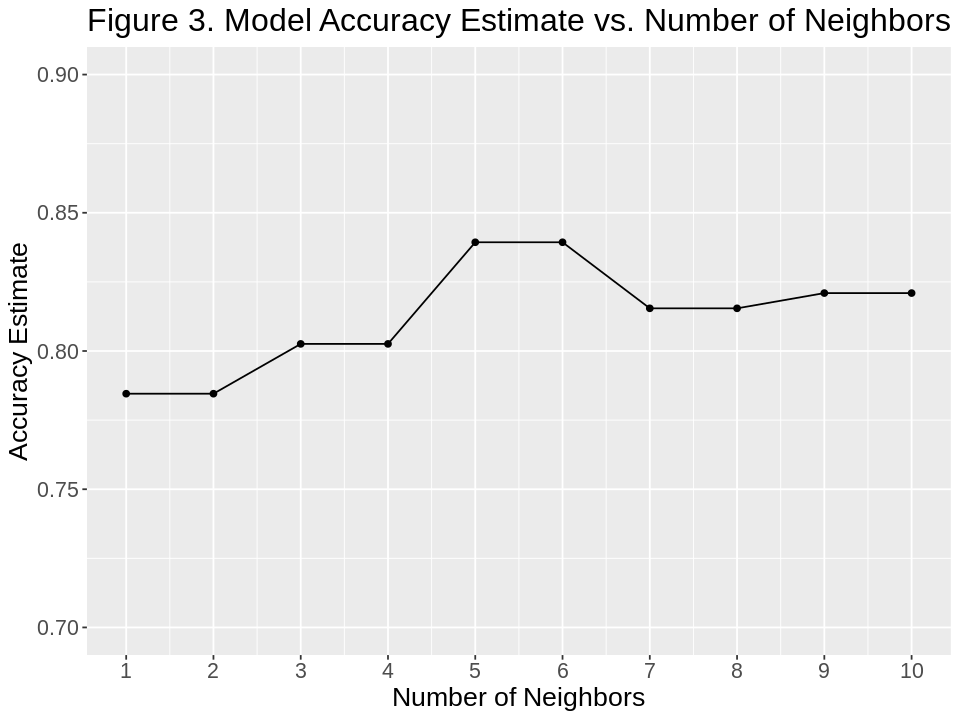

In [9]:
k_plot

In **Figure 3**, we observe optimal accuracy at K = 5, which is followed by little change in accuracy for larger values of K. Thus, we choose K = 5 to train our model.

### *Training Model*

Now that we have selected our predictors and tuned our K parameter, we train our model using our training data.

In [10]:
# get optimal K value
k_val <- k_best %>% pull(neighbors)

model_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_val) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# train model
model_fit <- workflow() %>%
    add_recipe(model_recipe) %>%
    add_model(model_spec) %>%
    fit(data_train)

model_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~k_val,     kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1790123
Best kernel: rectangular
Best k: 5

## IV. Results

At last, we use our model to predict the labels of our test data. By comparing our predictions against the true labels, we  evaluate our model's accuracy and then create the corresponding confusion matrix.

In [11]:
# make predictions using test data
model_preds <- model_fit %>%
    predict(data_test) %>%
    bind_cols(data_test)

# evaluate accuracy of model
model_metrics <- model_preds %>%
    metrics(truth = status, estimate = .pred_class) %>%
    filter(.metric == "accuracy")

# make confusion matrix
conf_matrix <- model_preds %>% 
    conf_mat(truth = status, estimate = .pred_class)

model_metrics 
conf_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8490566


            Truth
Prediction   Placed Not Placed
  Placed         34          5
  Not Placed      3         11

###### **Table 5**: Final model accuracy and the corresponding confusion matrix. It shows that 34 students were correctly predicted as "Placed" while 11 were correctly predicted as being "Not Placed".

**Table 5** shows that our model has a rather high accuracy of 85%, with a higher tendency of falsely predicting a student as Placed rather than Not Placed as evident in the confusion matrix. Based on these accuracy results, it appears that we can indeed predict work placement status using a student's secondary school, high school, and undergraduate degree percentages, which answers our original research question! **Figures 4,5,6** also highlight this by showing how a student's work placement status can visually be predicted when given their secondary school, high school, and undergraduate degree percentages.

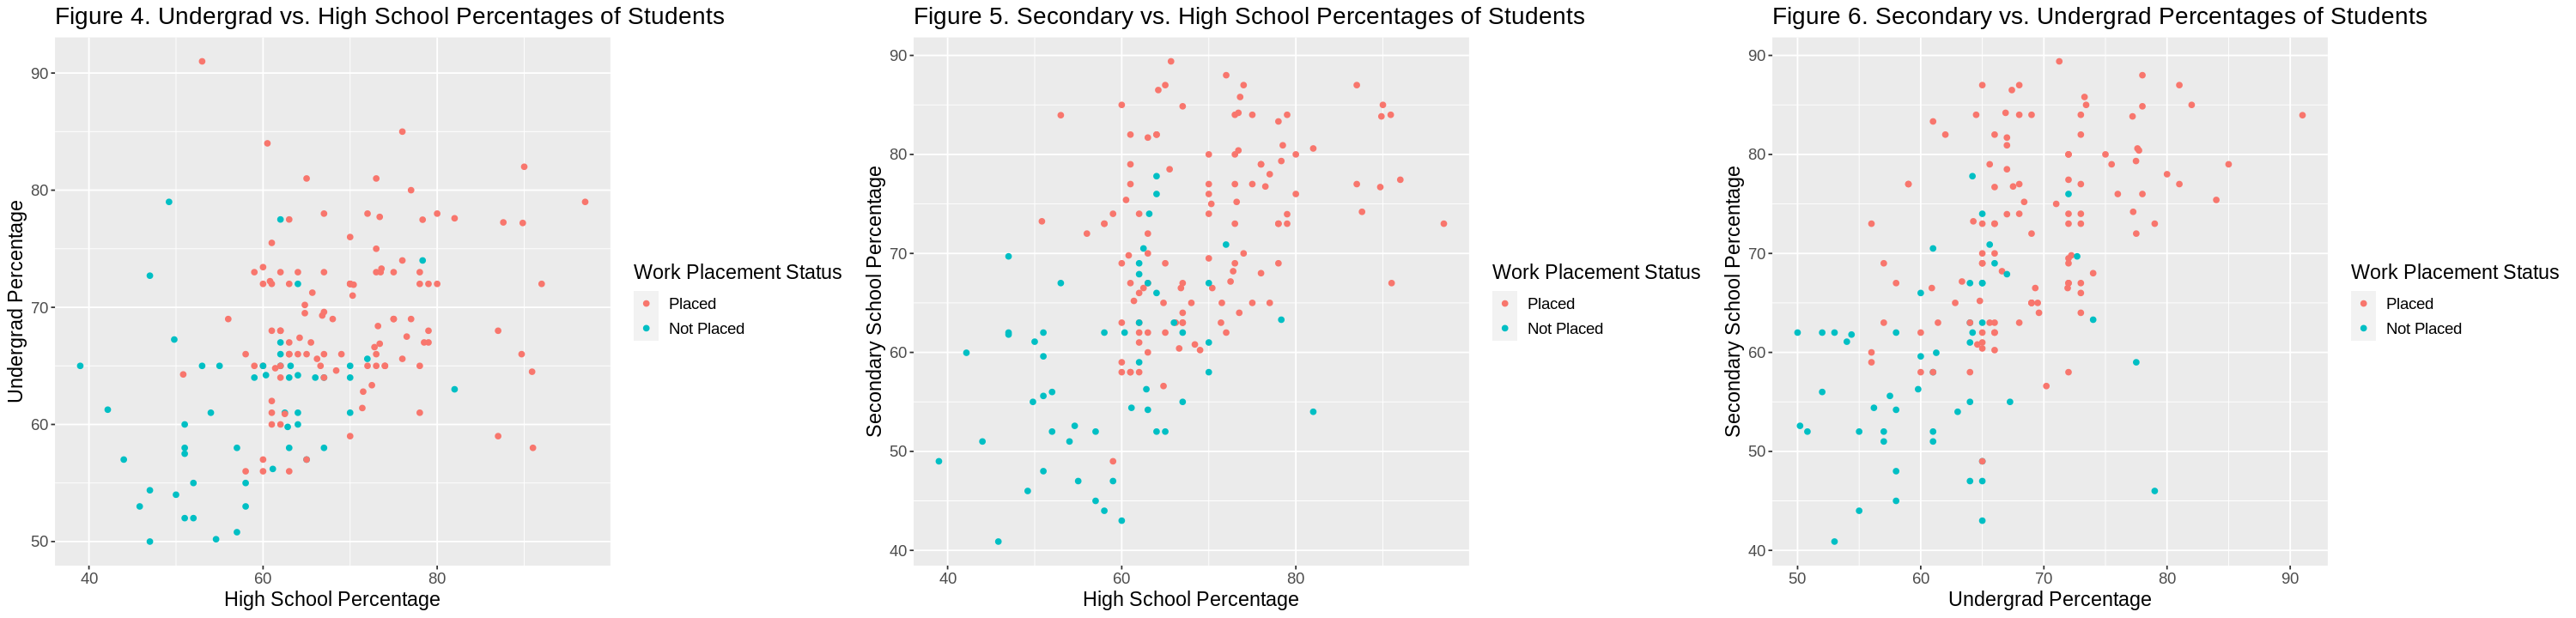

In [12]:
# make a plot grid to show scatterpltos of all pairings of predictors
options(repr.plot.width = 25, repr.plot.height = 6)

plot1 <- ggplot(data_train, aes(x = hsc_p, y = degree_p, color = status)) +
    geom_point() +
    labs(color = "Work Placement Status") +
    xlab("High School Percentage") +
    ylab("Undergrad Percentage") +
    ggtitle("Figure 4. Undergrad vs. High School Percentages of Students") +
    theme(text = element_text(size = 14))

plot2 <- ggplot(data_train, aes(x = hsc_p, y = ssc_p, color = status)) +
    geom_point() +
    labs(color = "Work Placement Status") +
    xlab("High School Percentage") +
    ylab("Secondary School Percentage") +
    ggtitle("Figure 5. Secondary vs. High School Percentages of Students") +
    theme(text = element_text(size = 14))

plot3 <- ggplot(data_train, aes(x = degree_p, y = ssc_p, color = status)) +
    geom_point() +
    labs(color = "Work Placement Status") +
    xlab("Undergrad Percentage") +
    ylab("Secondary School Percentage") +
    ggtitle("Figure 6. Secondary vs. Undergrad Percentages of Students") +
    theme(text = element_text(size = 14))


plot_grid <- plot_grid(plot1, plot2, plot3, ncol = 3)
plot_grid

## V. Discussion

From our preliminary exploration, we observed that students appeared in distinct groups relative to their work placement status. The group of Placed students often had higher academic averages than the group of Not Placed students (**Table 2**). These observations led us to expect that work placement status could indeed be predicted by academic percentages, which we have now confirmed using our model's accuracy results (**Table 5**). Furthermore, this result also matches the findings in available literature. As an example, according to CNBC's Ruth Umoh (2018), many employers currently believe that a strong GPA suggests that a candidate will be able to handle work pressure. This indicates that employers would be more likely to hire students with higher GPAs, as similarly suggested by our model .

Nonetheless, it is also important to remember that other factors may also get considered when hiring a student. For example, as Peter A. Gudmundsson from U.S. News (2020) mentions, companies nowdays are trying to put more emphasis on the experiences of the candidate rather than solely focusing on their academic performance. This suggests that our model may not be able to make accurate predictions in the future as more companies begin to prioritize one's experiences over  their academic percentages. As a result, we note than our model should ideally be used for students who are currently trying to assess their potential of being hired based on their academic percentages. We believe that the predictions of our model for such students will be impactful since it will inform them on whether they should maintain or change their study habits in order to improve their academic percentages for a work placement.

## VI. Future Questions

As for future investigations, it will be interesting to see whether our results apply to other countries. We acknowledge that our dataset only contains information on Indian students from a particular college and within a particular degree, so our results may not apply to students from other regions. It may also be valuable to take into account other pontential contributing factors, such as gender, socio-economic status, and race, when predicting the placement of students in the workplace. By conducting this investigation with datasets from different countries and by taking into account more individual characteristics, we will see whether or not work placement status can be predicted from academic percentages in other countries and also gain a deeper understanding of the other factors that contribute to the work placement status of students. 

## VII. References

1)  Gundmundsson, P. A. (2020, 15 May). *Does GPA Matter When Job Searching?* U.S. News https://money.usnews.com/money/blogs/outside-voices-careers/articles/does-gpa-matter-when-job-searching?fbclid=IwAR2JenJbYjlaueg28-3bQk-oEAk9BGr_nEQ6ofWeUchiPMlBFL3YCH5HuGU

2) Mehmetaj, N., Alili, M.Z. (2021). Employment of economics graduates: Do grade point averages matter? *Interdisciplinary Description of Complex Systems*. *19*(2), 210-226. DOI: 10.7906/indecs.19.2.3.

3) Roshan, B. (2020) *Campus Recruitment*. Kaggle. https://www.kaggle.com/datasets/benroshan/factors-affecting-campus-placement 

4) Sandvig, J.C. (2005). Determinants of Graduating MIS Sudents Starting Salary in Boom and Bust Job Markets, *Communications of the Association for Information Systems*. *16*, 604-624. DOI: 10.17705/1CAIS.01629.

5) Umoh, R. (2018, 13 July). *This is the only time you should include a GPA on your Resume*. CNBC. https://www.cnbc.com/2018/07/31/when-to-include-your-gpa-on-your-resume.html?fbclid=IwAR3yt4ZyyChJ7-JXRXp0BAl73vzxna88mPlY1zw5cELOu_w7Him_-CD5_fQ
